# Preprocesado

## Descargamos datos de kaggle

In [68]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip udea*.zip > /dev/null

In [4]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


In [9]:
!pip install unidecode fuzzywuzzy

## Librerías necesarias

In [11]:
import unidecode as ud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Cargar Dataset

In [70]:
filename = 'train.csv'
df = pd.read_csv(filename)

## Vistazo rápido a los datos

In [71]:
df.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [72]:
print("Shape", df.shape)

Shape (692500, 21)


In [73]:
print("Columnas:", list(df.columns))
print("\nTipos de datos:\n", df.dtypes)

Columnas: ['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']

Tipos de datos:
 ID                                  int64
PERIODO                             int64
ESTU_PRGM_ACADEMICO                object
ESTU_PRGM_DEPARTAMENTO             object
ESTU_VALORMATRICULAUNIVERSIDAD     object
ESTU_HORASSEMANATRABAJA            object
FAMI_ESTRATOVIVIENDA               object
FAMI_TIENEINTERNET                 object
FAMI_EDUCACIONPADRE                object
FAMI_TIENELAVADORA                 object
FAMI_TIENEAUTOMOVIL                object
ESTU_PRIVADO_LIBERTAD              object
ESTU_PAGOMATRICULAPROPIO           objec

## Valores nulos

In [77]:
print("\nValores nulos por columna:")
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
missing = pd.concat([missing_data, missing_percent], axis=1, keys=['Total', 'Porcentaje'])
display(missing[missing['Total'] > 0])


Valores nulos por columna:


,Total,Porcentaje
FAMI_TIENEAUTOMOVIL,43623,6.299350
FAMI_TIENELAVADORA,39773,5.743394
FAMI_TIENECOMPUTADOR,38103,5.502238
FAMI_ESTRATOVIVIENDA,32137,4.640722
ESTU_HORASSEMANATRABAJA,30857,4.455884
FAMI_TIENEINTERNET.1,26629,3.845343
FAMI_TIENEINTERNET,26629,3.845343
FAMI_EDUCACIONMADRE,23664,3.417184
FAMI_EDUCACIONPADRE,23178,3.347004
ESTU_PAGOMATRICULAPROPIO,6498,0.938339


## Estadísticas descriptivas para columnas numéricas

In [78]:
print("\nEstadísticas descriptivas:")
display(df.describe())


Estadísticas descriptivas:


,ID,PERIODO,coef_1,coef_2,coef_3,coef_4
count,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000
mean,494606.130576,20198.366679,0.268629,0.259996,0.262087,0.262903
std,285585.209455,10.535037,0.122130,0.093480,0.058862,0.067944
min,1.000000,20183.000000,0.000000,0.000000,0.000000,0.000000
25%,247324.750000,20195.000000,0.203000,0.212000,0.254000,0.255000
50%,494564.500000,20195.000000,0.240000,0.271000,0.276000,0.285000
75%,741782.500000,20203.000000,0.314000,0.309000,0.293000,0.303000
max,989286.000000,20213.000000,0.657000,0.487000,0.320000,0.332000


## Visualización inicial

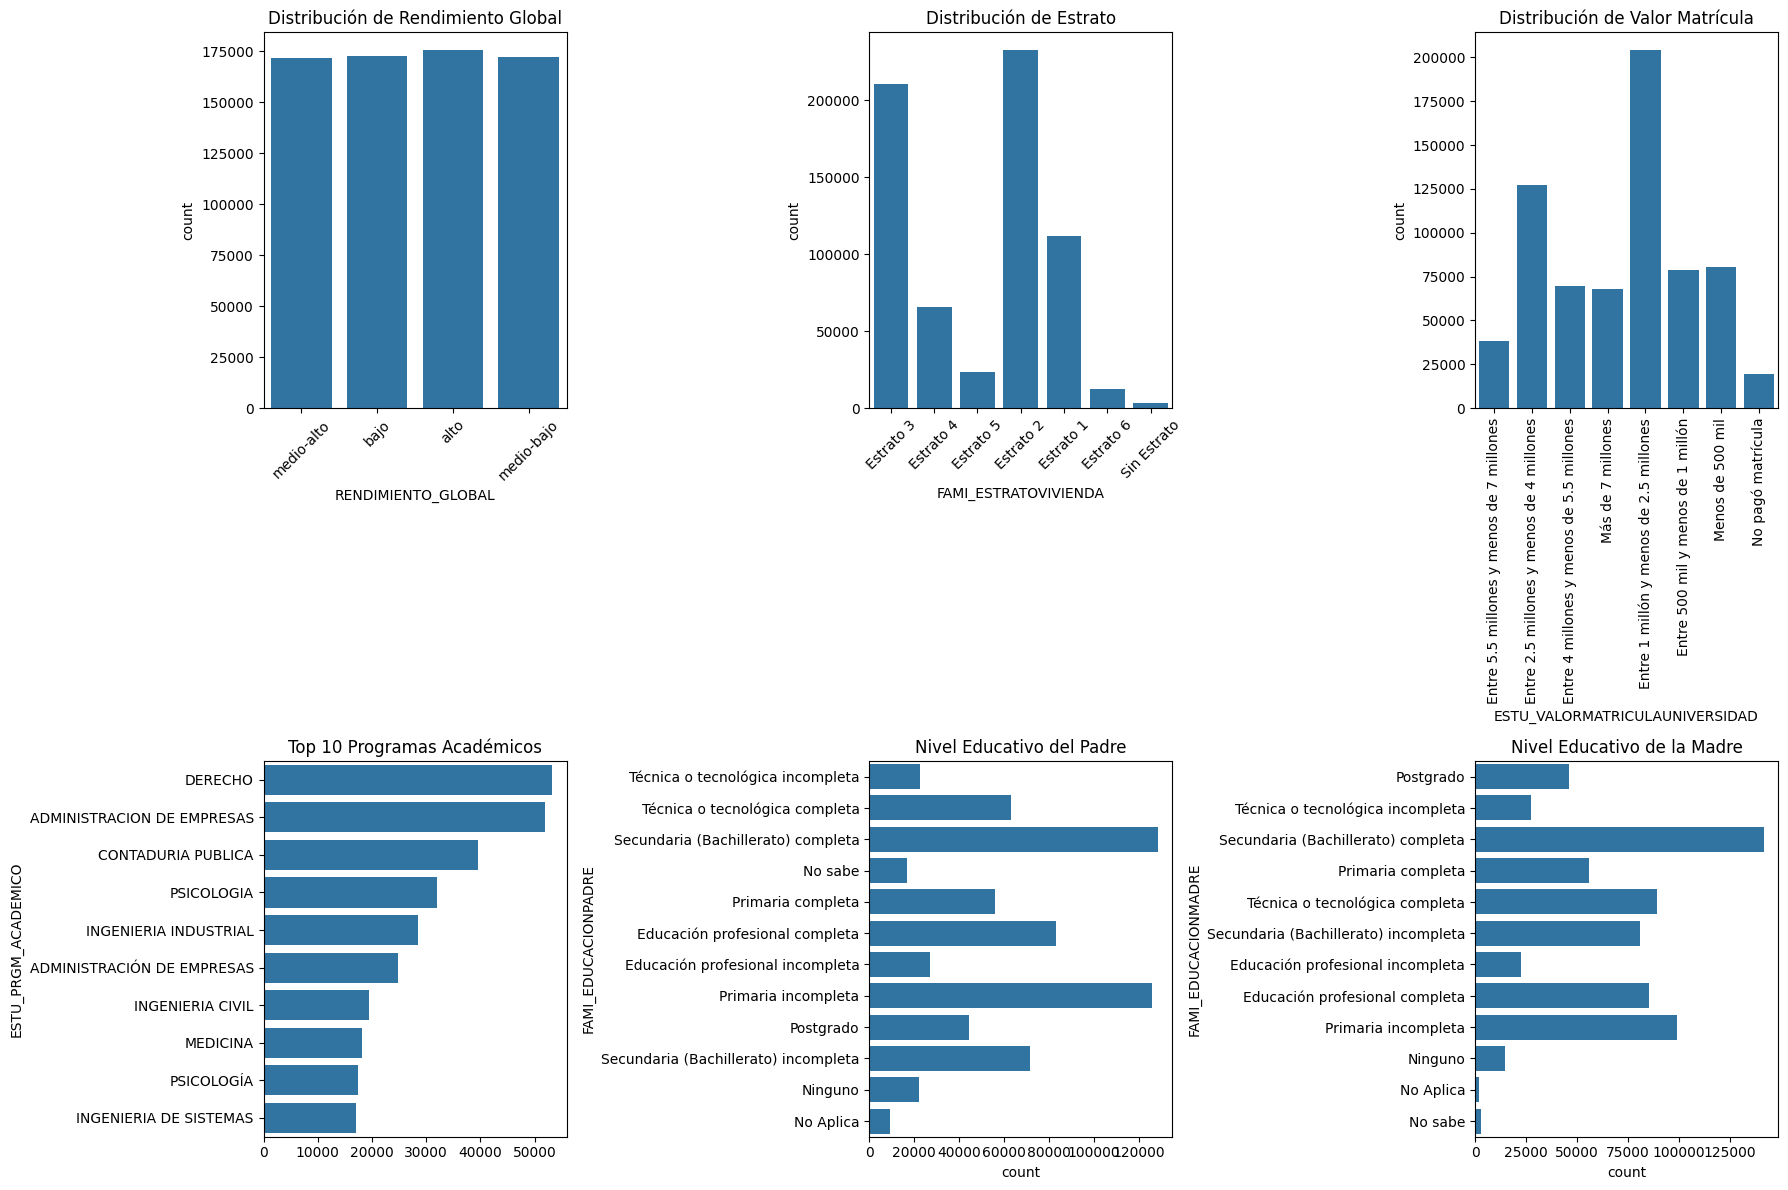

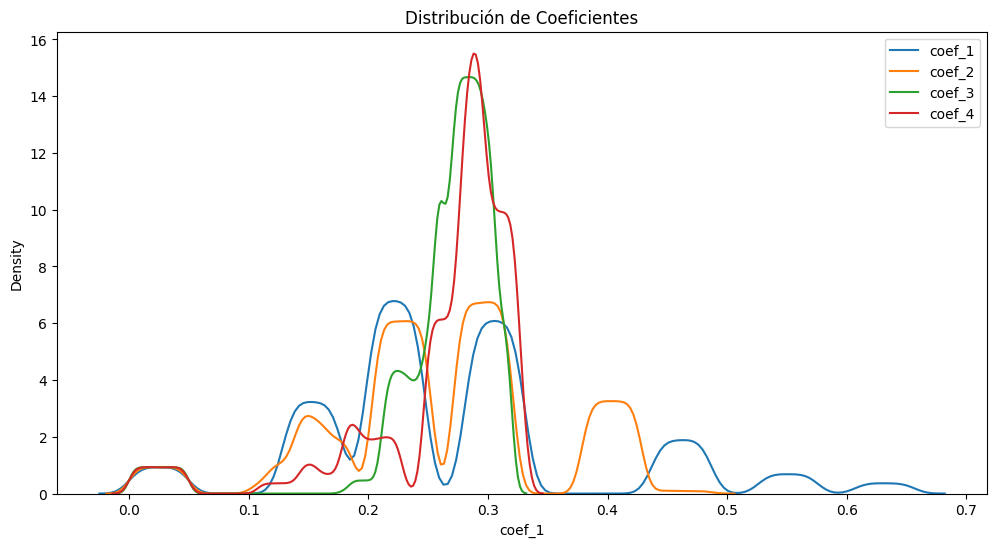

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.countplot(x='RENDIMIENTO_GLOBAL', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Rendimiento Global')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.countplot(x='FAMI_ESTRATOVIVIENDA', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Estrato')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(x='ESTU_VALORMATRICULAUNIVERSIDAD', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Distribución de Valor Matrícula')
axes[0, 2].tick_params(axis='x', rotation=90)

top_programs = df['ESTU_PRGM_ACADEMICO'].value_counts().head(10)
sns.barplot(x=top_programs.values, y=top_programs.index, ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Programas Académicos')

sns.countplot(y='FAMI_EDUCACIONPADRE', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Nivel Educativo del Padre')

sns.countplot(y='FAMI_EDUCACIONMADRE', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Nivel Educativo de la Madre')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for col in ['coef_1', 'coef_2', 'coef_3', 'coef_4']:
    sns.kdeplot(df[col], label=col)
plt.title('Distribución de Coeficientes')
plt.legend()
plt.show()

## Tratamiento de valores nulos

In [80]:
df_processed = df.copy()

print("Cantidad de valores nulos antes del tratamiento:")
print(f"Valor matrícula: {df_processed['ESTU_VALORMATRICULAUNIVERSIDAD'].isna().sum()}")
print(f"Horas semanales trabaja: {df_processed['ESTU_HORASSEMANATRABAJA'].isna().sum()}")
print(f"Estrato vivienda: {df_processed['FAMI_ESTRATOVIVIENDA'].isna().sum()}")
print(f"Educación padre: {df_processed['FAMI_EDUCACIONPADRE'].isna().sum()}")
print(f"Educación madre: {df_processed['FAMI_EDUCACIONMADRE'].isna().sum()}")
print(f"Pago matrícula propio: {df_processed['ESTU_PAGOMATRICULAPROPIO'].isna().sum()}")
print(f"Rendimiento global: {df_processed['RENDIMIENTO_GLOBAL'].isna().sum()}")

columns_to_fill = [
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'ESTU_HORASSEMANATRABAJA',
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_PAGOMATRICULAPROPIO'
]

for col in columns_to_fill:
    df_processed[col] = df_processed[col].fillna("no info")

Cantidad de valores nulos antes del tratamiento:
Valor matrícula: 6287
Horas semanales trabaja: 30857
Estrato vivienda: 32137
Educación padre: 23178
Educación madre: 23664
Pago matrícula propio: 6498
Rendimiento global: 0


In [81]:
print("\nCantidad de valores nulos después del tratamiento:")
for col in columns_to_fill:
    print(f"{col}: {df_processed[col].isna().sum()}")


Cantidad de valores nulos después del tratamiento:
ESTU_VALORMATRICULAUNIVERSIDAD: 0
ESTU_HORASSEMANATRABAJA: 0
FAMI_ESTRATOVIVIENDA: 0
FAMI_EDUCACIONPADRE: 0
FAMI_EDUCACIONMADRE: 0
ESTU_PAGOMATRICULAPROPIO: 0


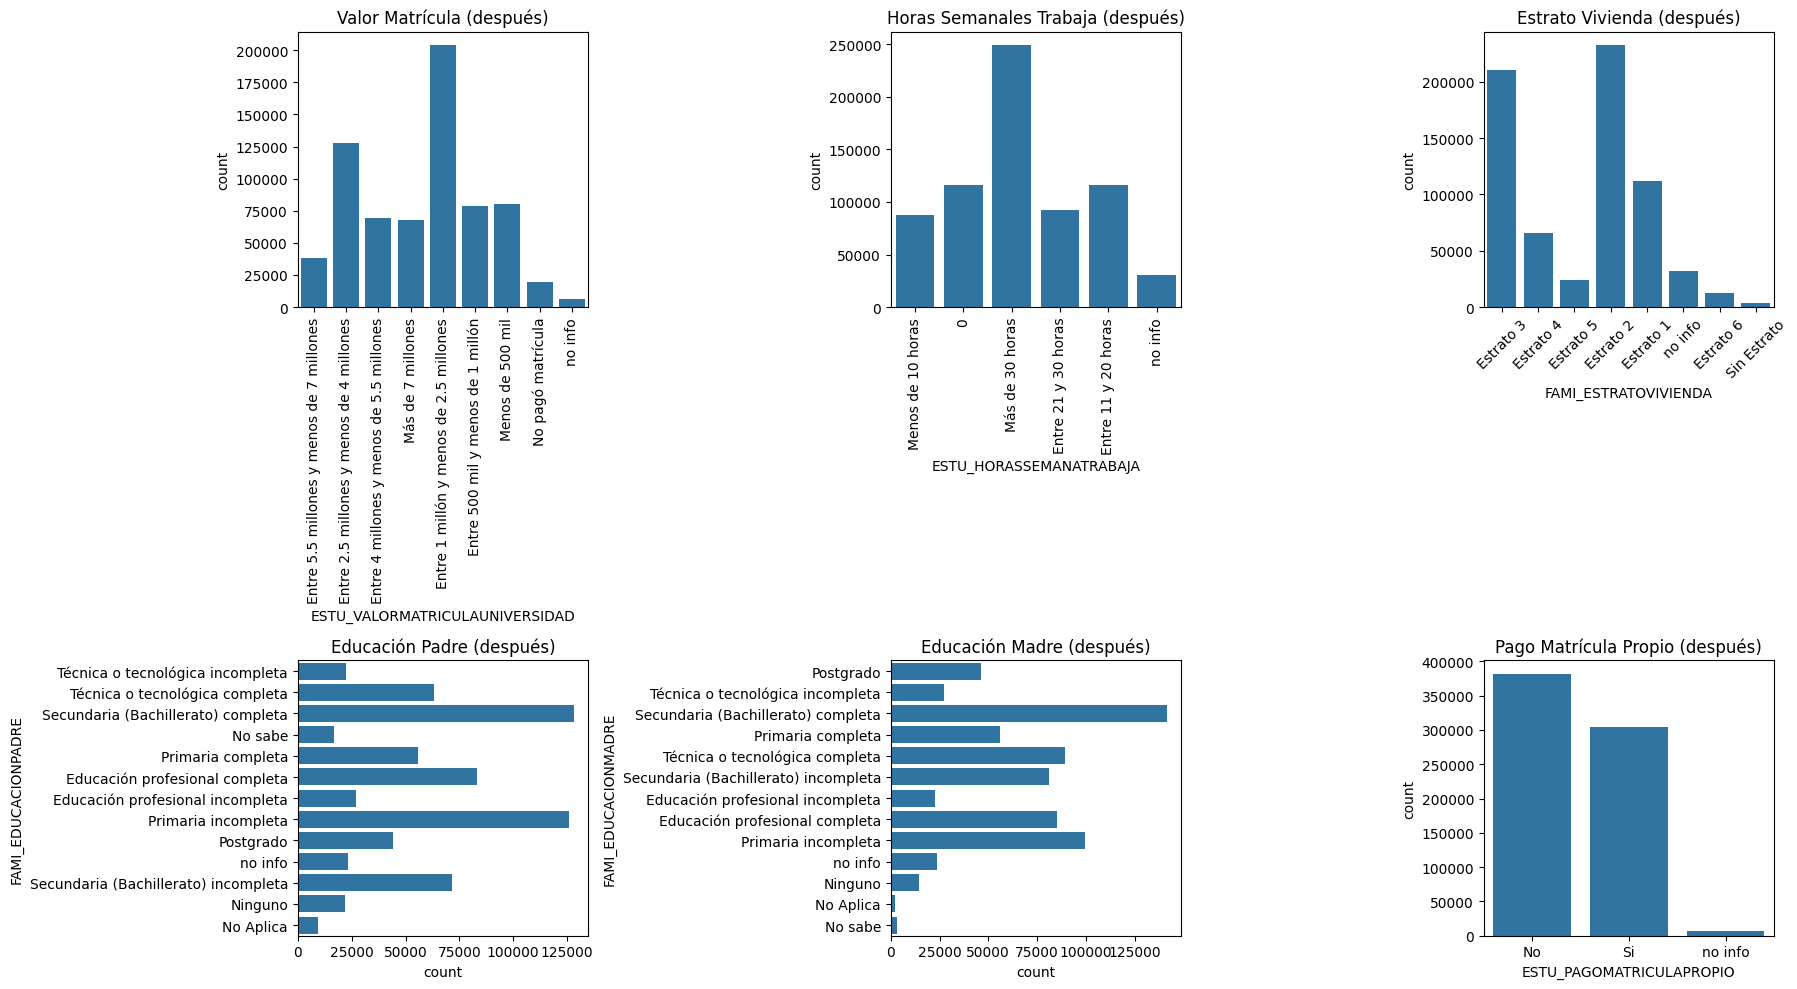

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.countplot(x='ESTU_VALORMATRICULAUNIVERSIDAD', data=df_processed, ax=axes[0, 0])
axes[0, 0].set_title('Valor Matrícula (después)')
axes[0, 0].tick_params(axis='x', rotation=90)

sns.countplot(x='ESTU_HORASSEMANATRABAJA', data=df_processed, ax=axes[0, 1])
axes[0, 1].set_title('Horas Semanales Trabaja (después)')
axes[0, 1].tick_params(axis='x', rotation=90)

sns.countplot(x='FAMI_ESTRATOVIVIENDA', data=df_processed, ax=axes[0, 2])
axes[0, 2].set_title('Estrato Vivienda (después)')
axes[0, 2].tick_params(axis='x', rotation=45)

sns.countplot(y='FAMI_EDUCACIONPADRE', data=df_processed, ax=axes[1, 0])
axes[1, 0].set_title('Educación Padre (después)')

sns.countplot(y='FAMI_EDUCACIONMADRE', data=df_processed, ax=axes[1, 1])
axes[1, 1].set_title('Educación Madre (después)')

sns.countplot(x='ESTU_PAGOMATRICULAPROPIO', data=df_processed, ax=axes[1, 2])
axes[1, 2].set_title('Pago Matrícula Propio (después)')

plt.tight_layout()
plt.show()

## Normalizar nombres de programas (lowercase y quitar acentos)

In [83]:
print("Conteo original de programas académicos:", df_processed['ESTU_PRGM_ACADEMICO'].nunique())
df_processed['ESTU_PRGM_ACADEMICO'] = df_processed['ESTU_PRGM_ACADEMICO'].apply(
    lambda x: ud.unidecode(str(x).lower())
)
print("Conteo después de normalizar:", df_processed['ESTU_PRGM_ACADEMICO'].nunique())

Conteo original de programas académicos: 948
Conteo después de normalizar: 786


## Distribución de programas antes de agrupar

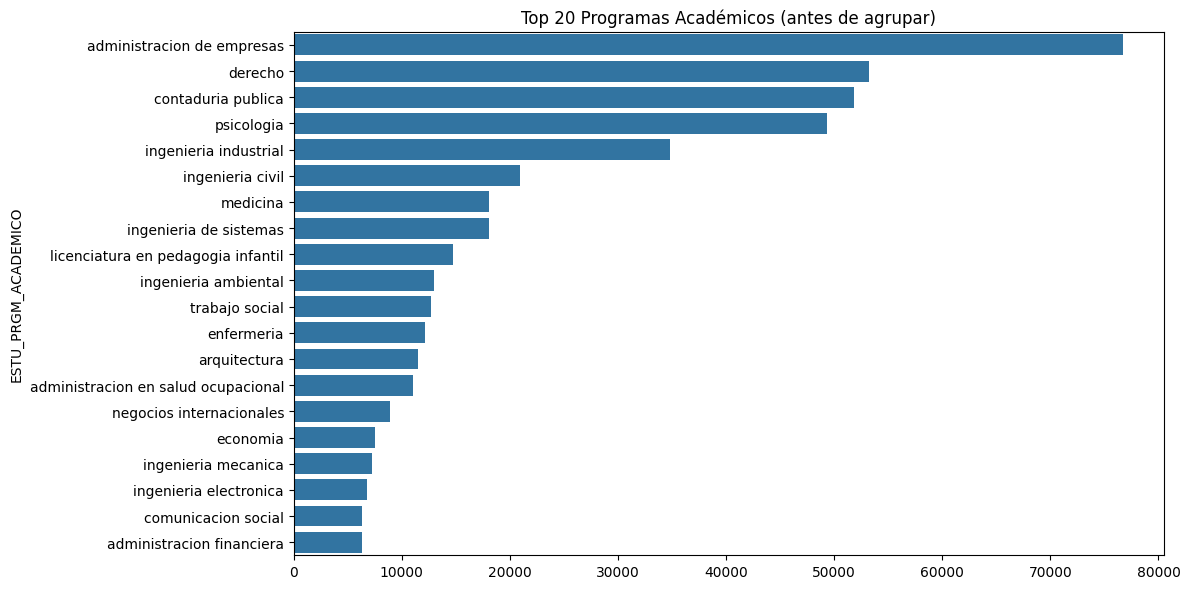

In [85]:
plt.figure(figsize=(12, 6))
top_20_before = df_processed['ESTU_PRGM_ACADEMICO'].value_counts().head(20)
sns.barplot(x=top_20_before.values, y=top_20_before.index)
plt.title('Top 20 Programas Académicos (antes de agrupar)')
plt.tight_layout()
plt.show()

## Agrupación

In [86]:
counts = df_processed['ESTU_PRGM_ACADEMICO'].value_counts()
prgm_acads = counts.loc[counts > 6000].index
print(f"Manteniendo {len(prgm_acads)} programas, el resto se agrupará como 'otros'")

df_processed['ESTU_PRGM_ACADEMICO_ORIGINAL'] = df_processed['ESTU_PRGM_ACADEMICO'].copy()
condition = ~df_processed['ESTU_PRGM_ACADEMICO'].isin(prgm_acads)
df_processed.loc[condition, 'ESTU_PRGM_ACADEMICO'] = "otros"

Manteniendo 20 programas, el resto se agrupará como 'otros'


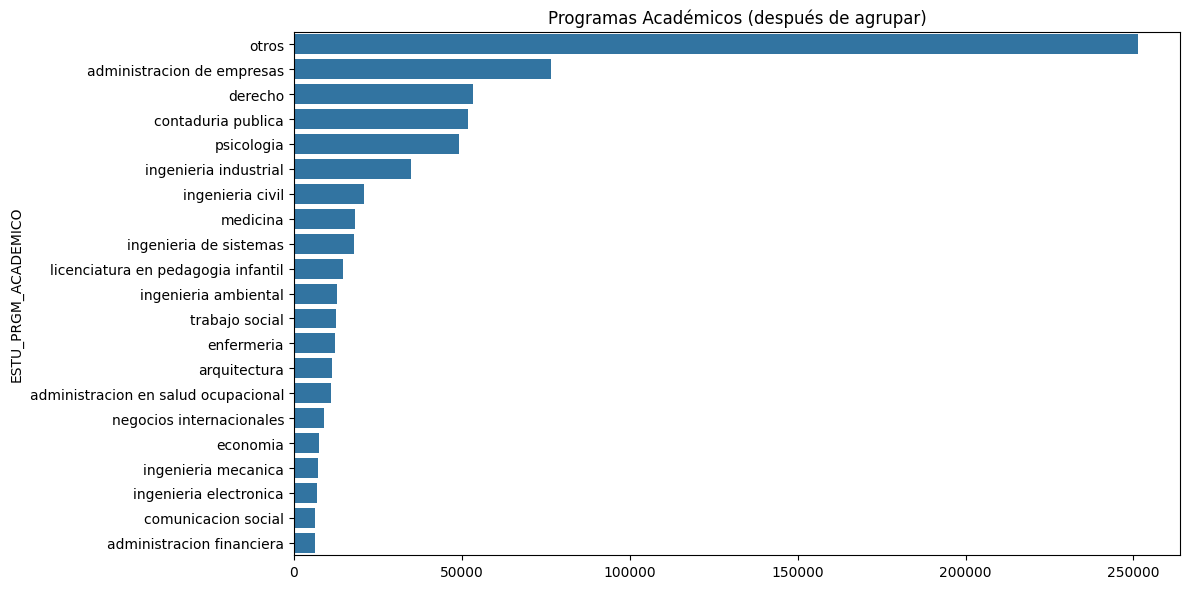

In [87]:
plt.figure(figsize=(12, 6))
after_grouping = df_processed['ESTU_PRGM_ACADEMICO'].value_counts()
sns.barplot(x=after_grouping.values, y=after_grouping.index)
plt.title('Programas Académicos (después de agrupar)')
plt.tight_layout()
plt.show()

## One-hot encoding para programas académicos

In [88]:
encoder = OneHotEncoder(sparse_output=False)
encoded_programs = encoder.fit_transform(df_processed[['ESTU_PRGM_ACADEMICO']])
encoded_df = pd.DataFrame(
    encoded_programs,
    columns=[f'prgm_{cat}' for cat in encoder.categories_[0]],
    index=df_processed.index
)

In [89]:
print("Primeras filas del one-hot encoding para programas académicos:")
display(encoded_df.head())

Primeras filas del one-hot encoding para programas académicos:


,prgm_administracion de empresas,prgm_administracion en salud ocupacional,prgm_administracion financiera,prgm_arquitectura,prgm_comunicacion social,prgm_contaduria publica,prgm_derecho,prgm_economia,prgm_enfermeria,prgm_ingenieria ambiental,...,prgm_ingenieria de sistemas,prgm_ingenieria electronica,prgm_ingenieria industrial,prgm_ingenieria mecanica,prgm_licenciatura en pedagogia infantil,prgm_medicina,prgm_negocios internacionales,prgm_otros,prgm_psicologia,prgm_trabajo social
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [90]:
df_processed = pd.concat([df_processed, encoded_df], axis=1)

##  Codificación ordinal para variables categóricas

In [91]:
ordinal_categories = {
    'ESTU_VALORMATRICULAUNIVERSIDAD': [
        'no info', 'No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón',
        'Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones',
        'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones',
        'Más de 7 millones'
    ],
    'ESTU_HORASSEMANATRABAJA': [
        'no info', '0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas'
    ],
    'FAMI_ESTRATOVIVIENDA': [
        'no info', 'Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6'
    ],
    'FAMI_EDUCACIONPADRE': [
        'no info', 'Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa',
        'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
        'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
    ],
    'FAMI_EDUCACIONMADRE': [
        'no info', 'Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa',
        'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
        'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
    ],
    'RENDIMIENTO_GLOBAL': [
        'no info', 'bajo', 'medio-bajo', 'medio-alto', 'alto'
    ]
}

df_before_ordinal = df_processed[list(ordinal_categories.keys())].copy()

ordinal_encoder = OrdinalEncoder(categories=[v for v in ordinal_categories.values()])

df_processed[list(ordinal_categories.keys())] = ordinal_encoder.fit_transform(
    df_processed[list(ordinal_categories.keys())]
)

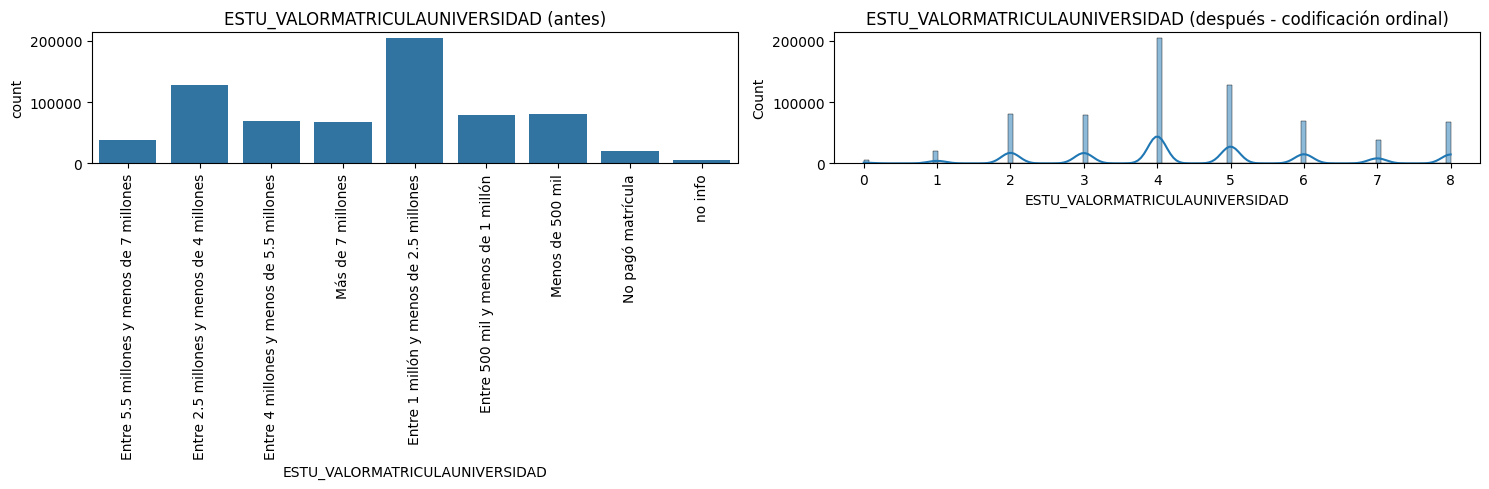

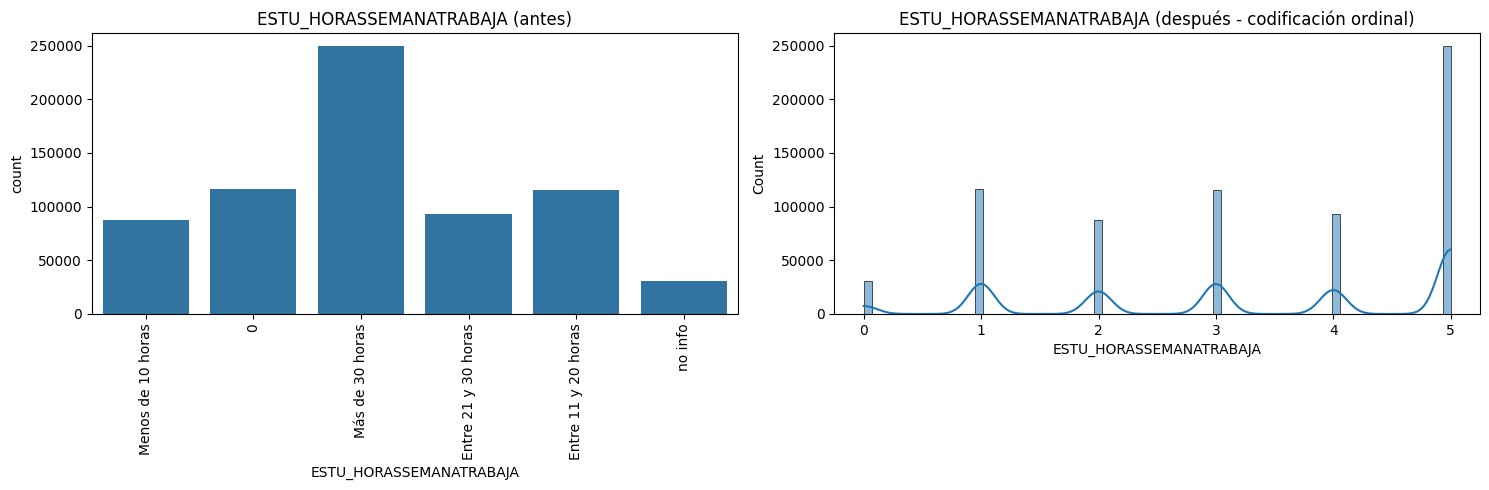

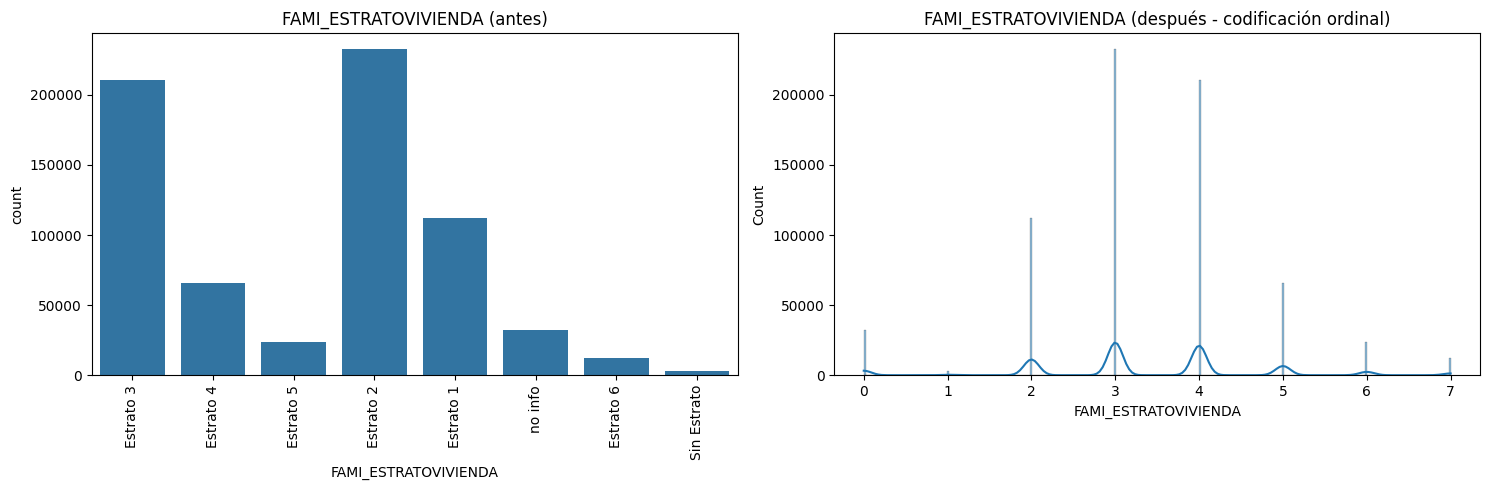

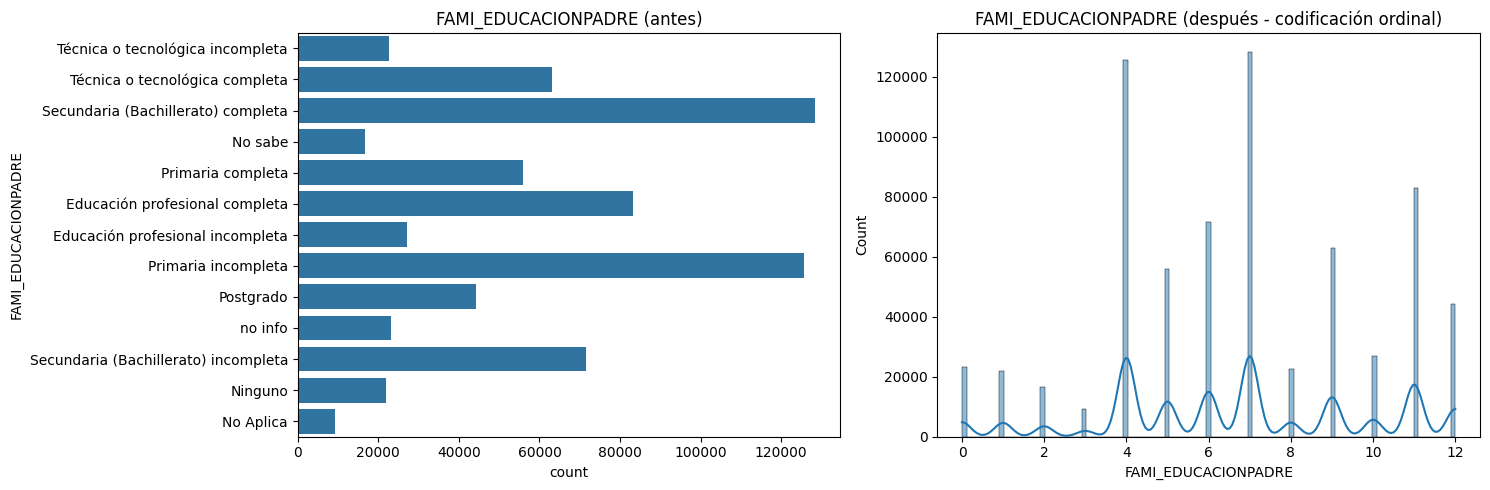

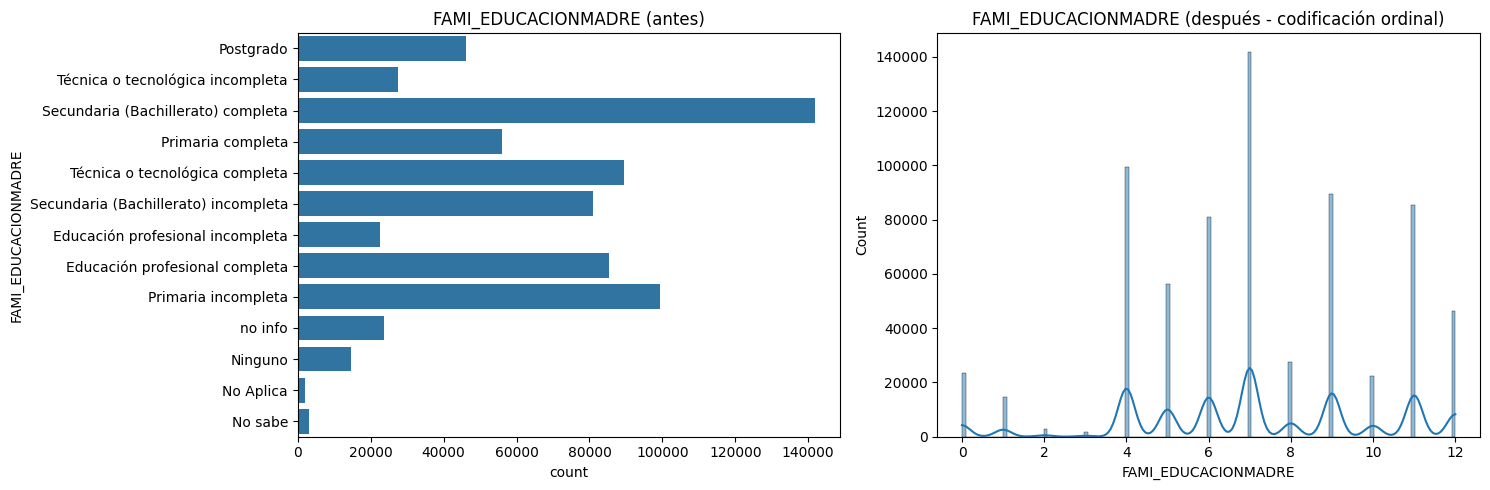

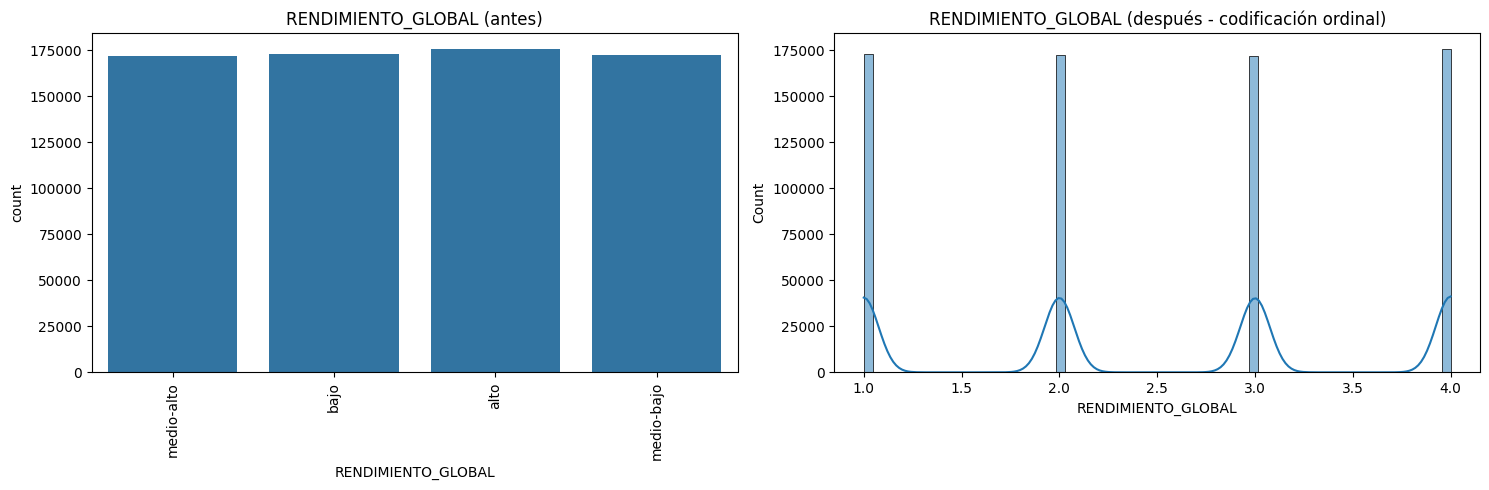

In [92]:
for i, col in enumerate(ordinal_categories.keys()):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))


    if df_before_ordinal[col].nunique() > 10:
        sns.countplot(y=col, data=df_before_ordinal, ax=axes[0])
    else:
        sns.countplot(x=col, data=df_before_ordinal, ax=axes[0])
        axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_title(f'{col} (antes)')

    sns.histplot(df_processed[col], kde=True, ax=axes[1])
    axes[1].set_title(f'{col} (después - codificación ordinal)')

    plt.tight_layout()
    plt.show()

## One-Hot Encoding para variables binarias


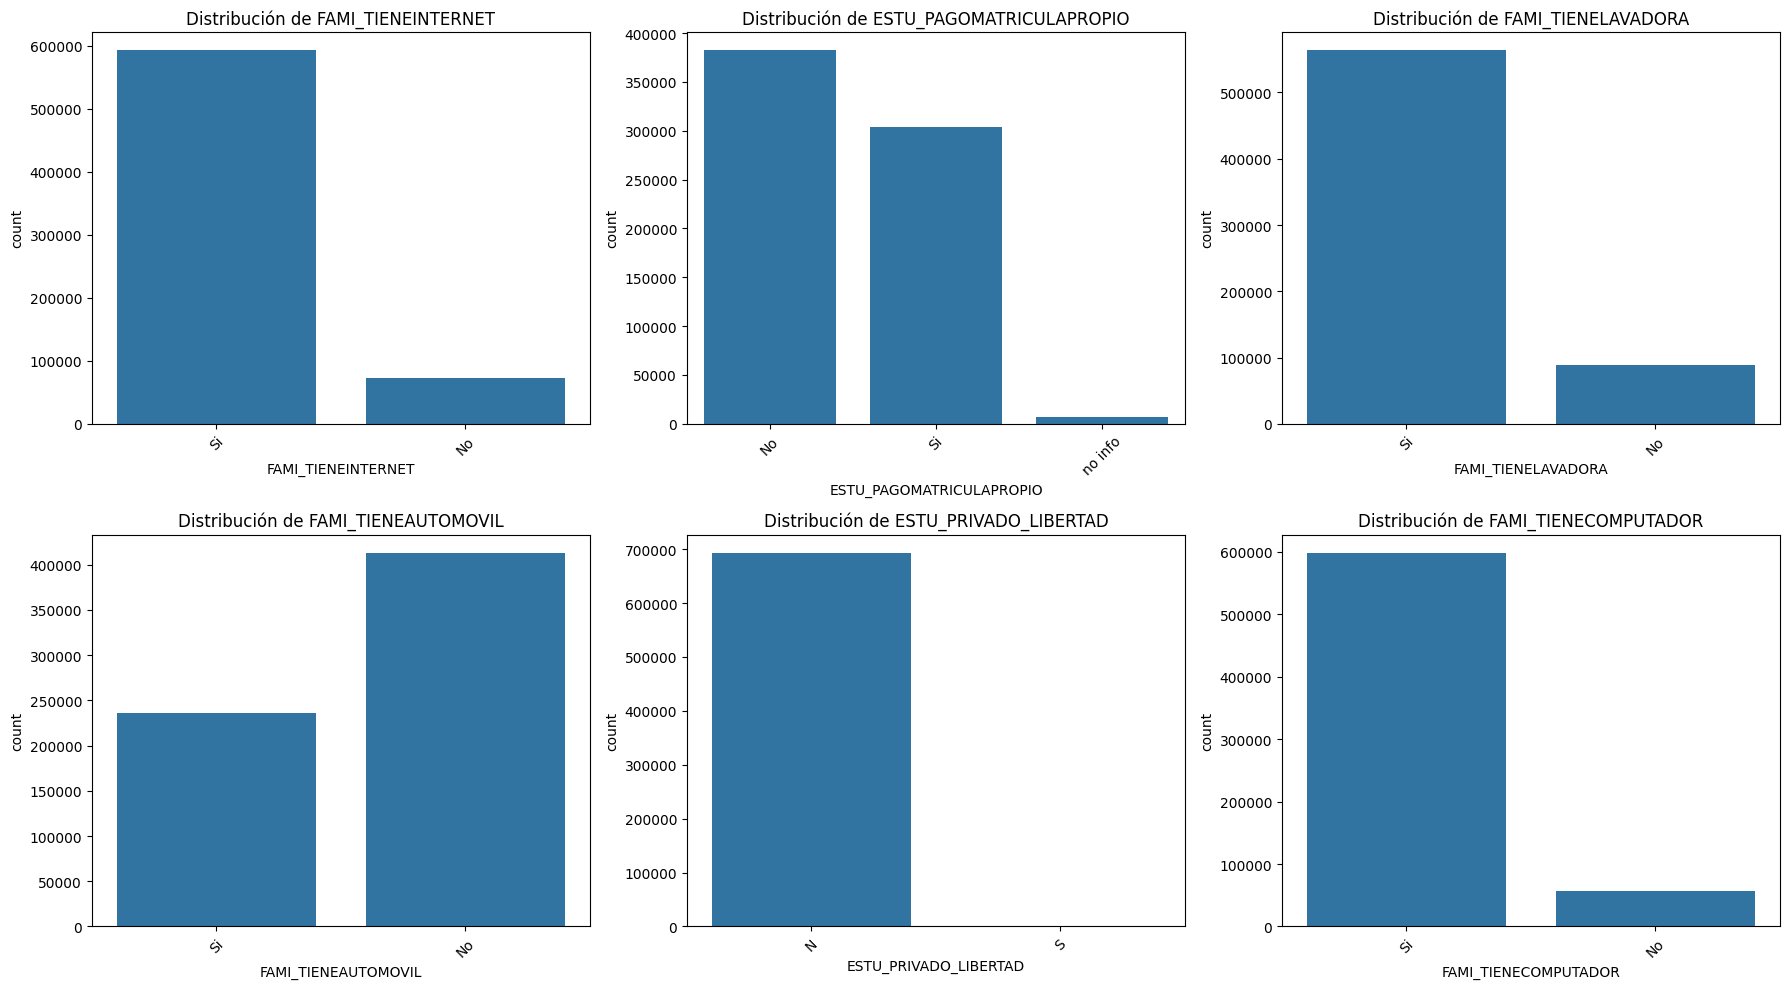

In [93]:
binary_vars = ['FAMI_TIENEINTERNET', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENELAVADORA',
               'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'FAMI_TIENECOMPUTADOR']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(binary_vars):
    sns.countplot(x=col, data=df_processed, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [94]:
for col in binary_vars:
    df_processed[col] = df_processed[col].fillna("no info")

    dummies = pd.get_dummies(df_processed[col], prefix=col)

    df_processed = pd.concat([df_processed, dummies], axis=1)

    df_processed.drop(col, axis=1, inplace=True)

In [95]:
print("Nuevas columnas después del One-Hot Encoding:")
one_hot_cols = [col for col in df_processed.columns if any(prefix in col for prefix in [f"{var}_" for var in binary_vars])]
print(one_hot_cols)

Nuevas columnas después del One-Hot Encoding:
['FAMI_TIENEINTERNET_No', 'FAMI_TIENEINTERNET_Si', 'FAMI_TIENEINTERNET_no info', 'ESTU_PAGOMATRICULAPROPIO_No', 'ESTU_PAGOMATRICULAPROPIO_Si', 'ESTU_PAGOMATRICULAPROPIO_no info', 'FAMI_TIENELAVADORA_No', 'FAMI_TIENELAVADORA_Si', 'FAMI_TIENELAVADORA_no info', 'FAMI_TIENEAUTOMOVIL_No', 'FAMI_TIENEAUTOMOVIL_Si', 'FAMI_TIENEAUTOMOVIL_no info', 'ESTU_PRIVADO_LIBERTAD_N', 'ESTU_PRIVADO_LIBERTAD_S', 'FAMI_TIENECOMPUTADOR_No', 'FAMI_TIENECOMPUTADOR_Si', 'FAMI_TIENECOMPUTADOR_no info']


## Manejo de columnas duplicadas

In [96]:
duplicate_cols = df_processed.columns[df_processed.columns.duplicated(keep=False)]
print("Columnas posiblemente duplicadas:", duplicate_cols.tolist())

Columnas posiblemente duplicadas: []


## Visualización final y guardado del dataset preprocesado

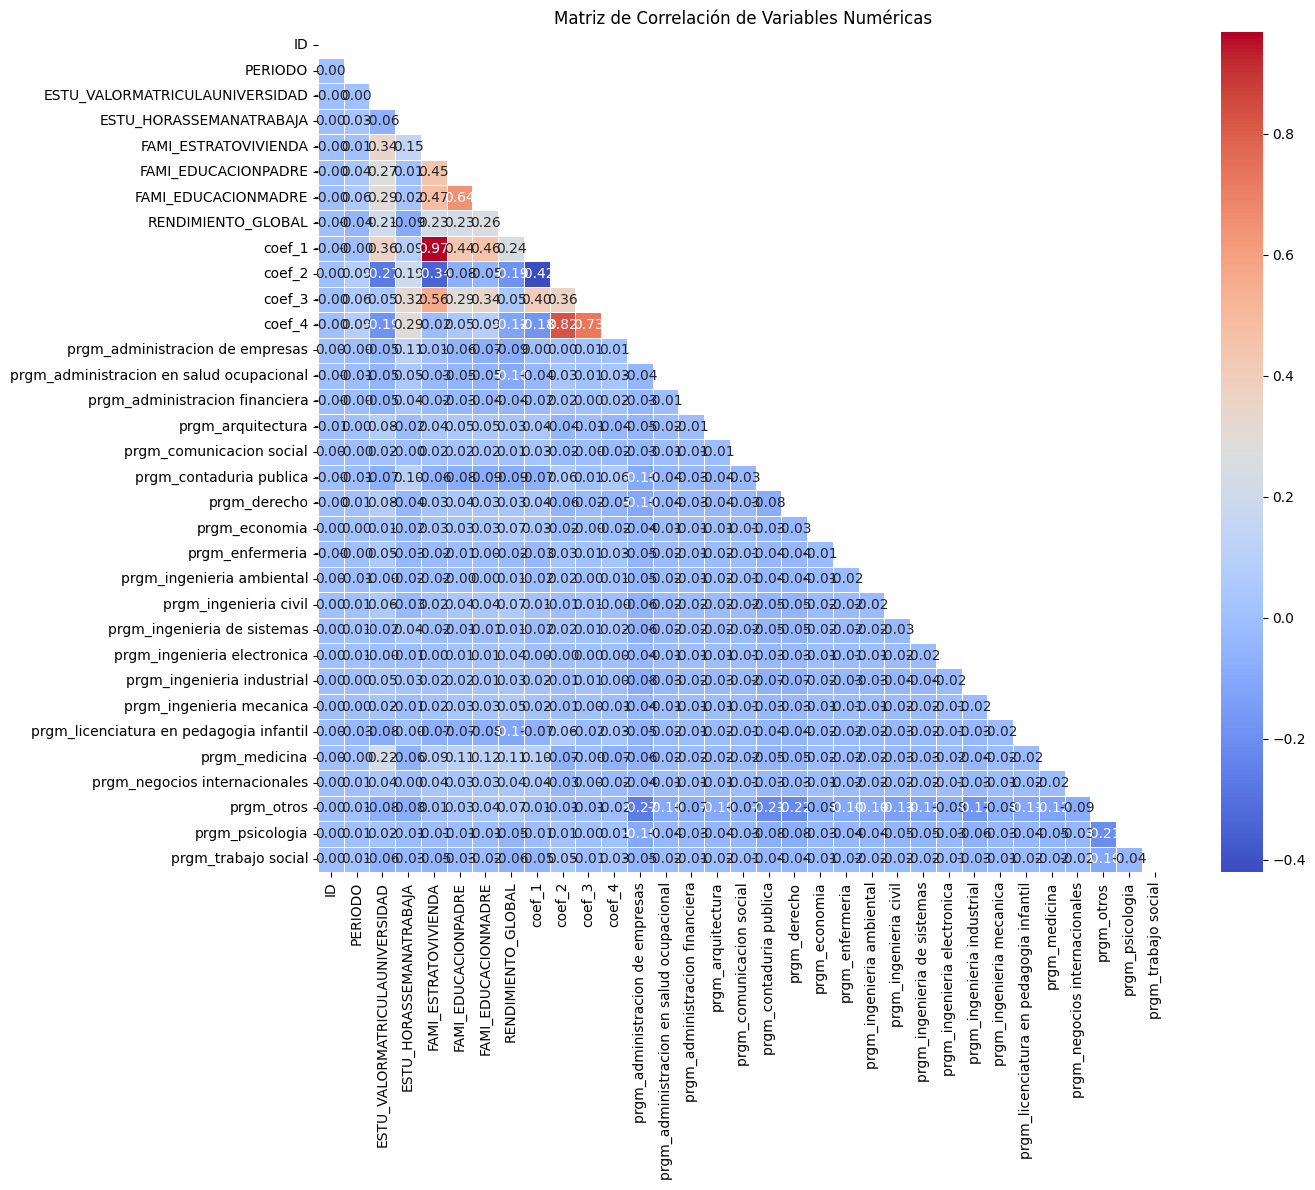

In [97]:
numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(14, 12))
correlation = df_processed[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

In [98]:
df_processed.to_csv('train_processed.csv', index=False)
print("Dataset preprocesado guardado como 'train_processed.csv'")

Dataset preprocesado guardado como 'train_processed.csv'


## Resumen

In [99]:
transformations = {
    "Valores nulos": f"Rellenados con 'no info' en {len(columns_to_fill)} columnas",
    "Programas académicos": f"Agrupados en {len(prgm_acads) + 1} categorías y aplicado One-Hot Encoding",
    "Variables ordinales": f"Codificación ordinal aplicada a {len(ordinal_categories)} columnas",
    "Variables binarias": f"One-Hot Encoding aplicado a {len(binary_vars)} columnas",
    "Dimensiones originales": f"{df.shape[0]} filas x {df.shape[1]} columnas",
    "Dimensiones finales": f"{df_processed.shape[0]} filas x {df_processed.shape[1]} columnas"
}

for key, value in transformations.items():
    print(f"{key}: {value}")

Valores nulos: Rellenados con 'no info' en 6 columnas
Programas académicos: Agrupados en 21 categorías y aplicado One-Hot Encoding
Variables ordinales: Codificación ordinal aplicada a 6 columnas
Variables binarias: One-Hot Encoding aplicado a 6 columnas
Dimensiones originales: 692500 filas x 21 columnas
Dimensiones finales: 692500 filas x 54 columnas
